[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_18944\812707727.py:92: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Model Intercept: {float(reg_model.intercept_):.2f}")


MultiIndex([( 'Close', '^GSPC'),
            (  'High', '^GSPC'),
            (   'Low', '^GSPC'),
            (  'Open', '^GSPC'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])
MultiIndex([( 'Close', '^TNX'),
            (  'High', '^TNX'),
            (   'Low', '^TNX'),
            (  'Open', '^TNX'),
            ('Volume', '^TNX')],
           names=['Price', 'Ticker'])
Mean Absolute Error: 216.76
R-squared Score: 0.50
Model Coefficients: [[  -3.0680191   436.53955792 -133.78913399]]
Model Intercept: 4042.71


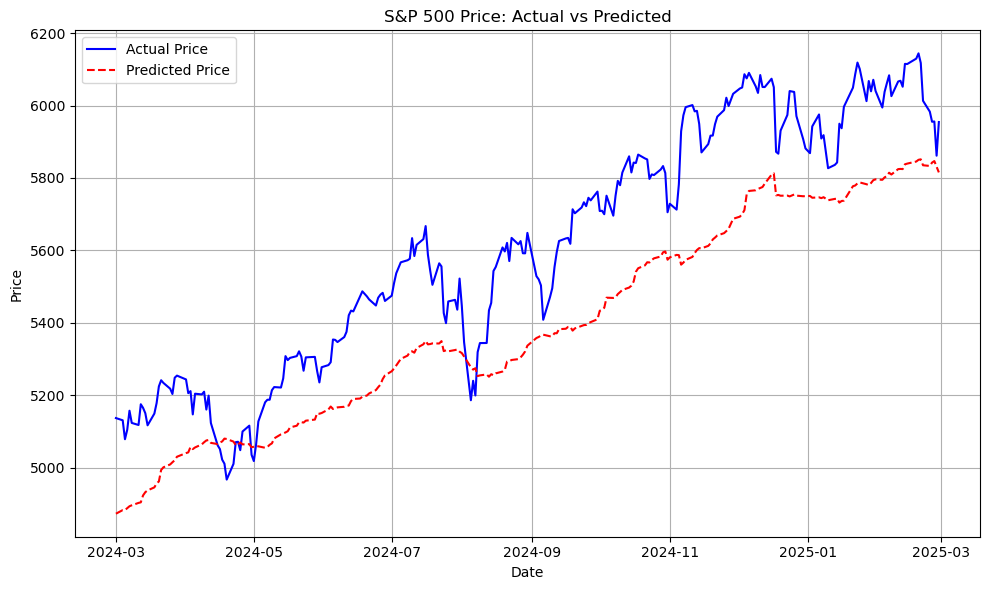

Model Accuracy: 0.98
Confusion Matrix:
[[109   0]
 [  5 136]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       109
           1       1.00      0.96      0.98       141

    accuracy                           0.98       250
   macro avg       0.98      0.98      0.98       250
weighted avg       0.98      0.98      0.98       250



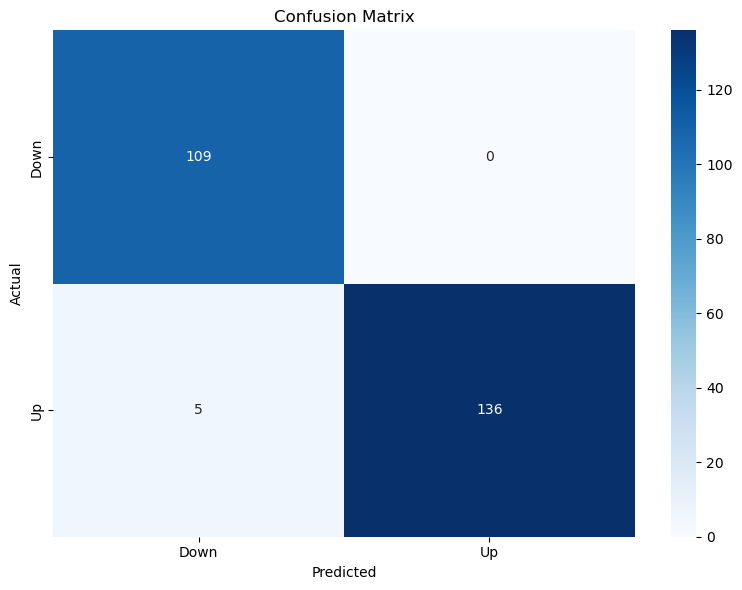

In [12]:
# S&P Treasury Yield ML Analysis

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, r2_score, classification_report, confusion_matrix, accuracy_score

# Step 1: Download financial data (S&P 500 and Treasury Yield)
# Define the time period
start = "2020-01-01"
end = "2025-03-01"

# Download S&P 500 data (^GSPC) and Treasury Yield (^TNX)
sp500 = yf.download('^GSPC', start=start, end=end)
tnx = yf.download('^TNX', start=start, end=end)

# Display the MultiIndex structure
print(pd.MultiIndex.from_product([['Close', 'High', 'Low', 'Open', 'Volume'], ['^GSPC']], 
                                names=['Price', 'Ticker']))
print(pd.MultiIndex.from_product([['Close', 'High', 'Low', 'Open', 'Volume'], ['^TNX']], 
                                names=['Price', 'Ticker']))

# Step 2: Feature Engineering for SP500
# Calculate Daily Return
sp500['Daily_Return'] = sp500['Close'].pct_change() * 100

# Market Direction: 1 is up, 0 is down
sp500['Market_Direction'] = (sp500['Close'] > sp500['Close'].shift(1)).astype(int)

# 50-day moving average
sp500['50_MA'] = sp500['Close'].rolling(window=50).mean()

# 20-day rolling volatility (standard deviation of returns)
sp500['Volatility'] = sp500['Daily_Return'].rolling(window=20).std()

# Drop NaN values created by rolling calculations
sp500_clean = sp500.dropna()

# Merge Treasury Yield data
# First, we need to align the indices (dates) of both dataframes
tnx_close = tnx[['Close']].rename(columns={'Close': 'Treasury_Yield'})
merged_data = pd.merge(sp500_clean, tnx_close, left_index=True, right_index=True, how='inner')

# Define Features (X) and Target (y)
# For regression: predict the actual S&P 500 price
X_reg = merged_data[['Treasury_Yield', '50_MA', 'Volatility']]
y_reg = merged_data['Close']

# For classification: predict market direction (up/down)
X_clf = merged_data[['Treasury_Yield', '50_MA', 'Volatility', 'Daily_Return']]
y_clf = merged_data['Market_Direction']

# Step 3: Train-Test Split (80%-20%)
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42, shuffle=False
)

X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, shuffle=False
)

# Step 4: Standardize Features
scaler = StandardScaler()
X_reg_train_scaled = scaler.fit_transform(X_reg_train)
X_reg_test_scaled = scaler.transform(X_reg_test)

scaler_clf = StandardScaler()
X_clf_train_scaled = scaler_clf.fit_transform(X_clf_train)
X_clf_test_scaled = scaler_clf.transform(X_clf_test)

# Step 5: Regression Model - Linear Regression to predict S&P 500 price
reg_model = LinearRegression()
reg_model.fit(X_reg_train_scaled, y_reg_train)
y_reg_pred = reg_model.predict(X_reg_test_scaled)

# Evaluate regression model
reg_mae = mean_absolute_error(y_reg_test, y_reg_pred)
reg_r2 = r2_score(y_reg_test, y_reg_pred)

# Print coefficients properly (they're an array for multiple features)
print(f"Mean Absolute Error: {reg_mae:.2f}")
print(f"R-squared Score: {reg_r2:.2f}")
print(f"Model Coefficients: {reg_model.coef_}")
print(f"Model Intercept: {float(reg_model.intercept_):.2f}")

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.plot(y_reg_test.index, y_reg_test, label='Actual Price', color='blue')
plt.plot(y_reg_test.index, y_reg_pred, label='Predicted Price', color='red', linestyle='--')
plt.title('S&P 500 Price: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 6: Classification Model - Logistic Regression to predict market direction
clf_model = LogisticRegression(random_state=42)
clf_model.fit(X_clf_train_scaled, y_clf_train)
y_clf_pred = clf_model.predict(X_clf_test_scaled)

# Evaluate classification model
clf_accuracy = accuracy_score(y_clf_test, y_clf_pred)
clf_confusion = confusion_matrix(y_clf_test, y_clf_pred)
clf_report = classification_report(y_clf_test, y_clf_pred)

print(f"Model Accuracy: {clf_accuracy:.2f}")
print(f"Confusion Matrix:\n{clf_confusion}")
print(f"Classification Report:\n{clf_report}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(clf_confusion, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()